In [2]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d

import numpy

rng = numpy.random.RandomState(23455)

# instantiate 4D tensor for input
input = T.tensor4(name='input')

# initialize shared variable for weights.
w_shp = (2, 3, 9, 9)
w_bound = numpy.sqrt(3 * 9 * 9)
W = theano.shared( numpy.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')

# initialize shared variable for bias (1D tensor) with random values
# IMPORTANT: biases are usually initialized to zero. However in this
# particular application, we simply apply the convolutional layer to
# an image without learning the parameters. We therefore initialize
# them to random values to "simulate" learning.
b_shp = (2,)
b = theano.shared(numpy.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv2d(input, W)

# build symbolic expression to add bias and apply activation function, i.e. produce neural net layer output
# A few words on ``dimshuffle`` :
#   ``dimshuffle`` is a powerful tool in reshaping a tensor;
#   what it allows you to do is to shuffle dimension around
#   but also to insert new ones along which the tensor will be
#   broadcastable;
#   dimshuffle('x', 2, 'x', 0, 1)
#   This will work on 3d tensors with no broadcastable
#   dimensions. The first dimension will be broadcastable,
#   then we will have the third dimension of the input tensor as
#   the second of the resulting tensor, etc. If the tensor has
#   shape (20, 30, 40), the resulting tensor will have dimensions
#   (1, 40, 1, 20, 30). (AxBxC tensor is mapped to 1xCx1xAxB tensor)
#   More examples:
#    dimshuffle('x') -> make a 0d (scalar) into a 1d vector
#    dimshuffle(0, 1) -> identity
#    dimshuffle(1, 0) -> inverts the first and second dimensions
#    dimshuffle('x', 0) -> make a row out of a 1d vector (N to 1xN)
#    dimshuffle(0, 'x') -> make a column out of a 1d vector (N to Nx1)
#    dimshuffle(2, 0, 1) -> AxBxC to CxAxB
#    dimshuffle(0, 'x', 1) -> AxB to Ax1xB
#    dimshuffle(1, 'x', 0) -> AxB to Bx1xA
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))

# create theano function to compute filtered images
f = theano.function([input], output)


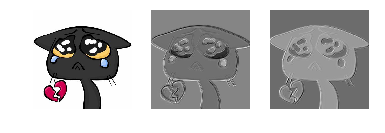

In [8]:
import numpy
import pylab
from PIL import Image

# open random image of dimensions 639x516
img = Image.open(open('/home/duclh/Workspace/Data/meow.jpg'))
# dimensions are (height, width, channel)
img = numpy.asarray(img, dtype='float64') / 256.

# put image in 4D tensor of shape (1, 3, height, width)
img_ = img.transpose(2, 0, 1).reshape(1, 3, 408, 408)
filtered_img = f(img_)

# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :])
pylab.show()